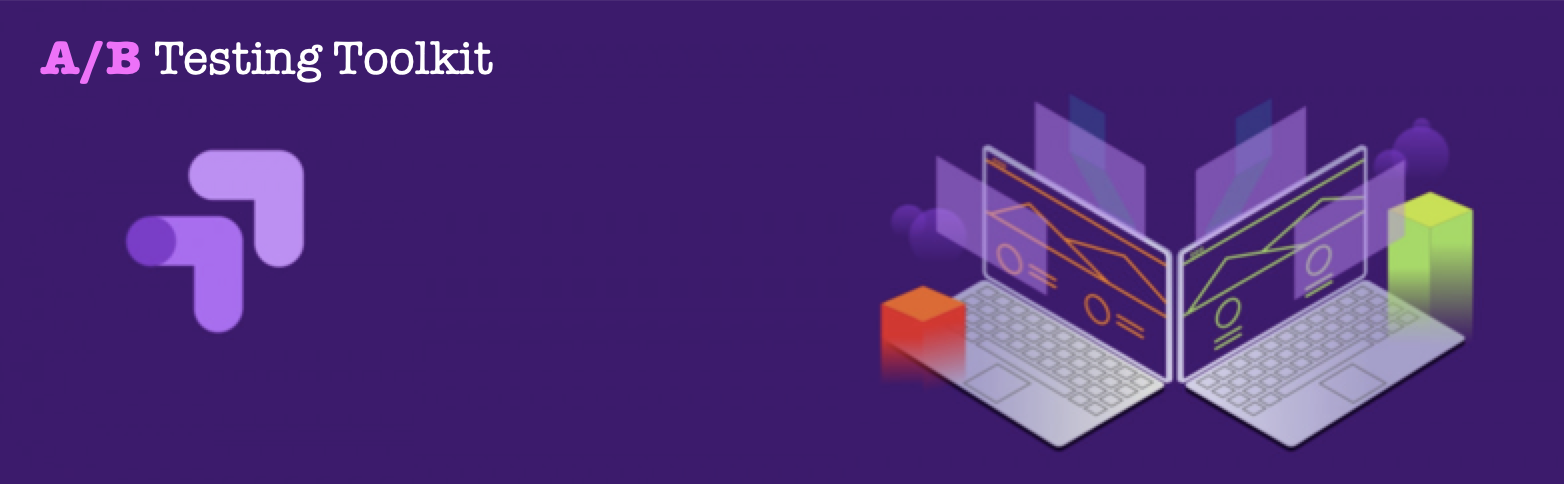

# Bayesian Estimation Supersedes the T-Test

Summary of the model for Bayesian estimation. The model describes the data with five parameters: a mean and standard deviation for each group and a normality parameter shared by the groups. The prior allocation of credibility across the fiveparameter space is very vague and wide, so that the prior has minimal influence on the estimation, and the data dominate the Bayesian inference. Bayesian estimation will reallocate credibility to parameter values that best accommodate the observed data. The resulting distribution is a joint distribution across the five parameters, thereby revealing combinations of the five parameter values that are credible, given the data. 


Taken and adapted from John Kruschke (2012): https://pdfs.semanticscholar.org/dea6/0927efbd1f284b4132eae3461ea7ce0fb62a.pdf?_ga=2.41739815.402975168.1603804236-67284617.1603804236

In [24]:
! pip install arviz
! pip install pymc3
! pip install best

In [23]:
# Import necessary packages for BEST analysis

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import seaborn as sb
import best as best

In [15]:
# Import data

local = 'tribalism_data.csv'
df = pd.read_csv(local, encoding= 'unicode_escape')
df.head()

,date,user_experience,session,pre_exp_metric,exp_metric,whatshot_clicks,mostread_clicks,isMobile,browser,operatingSystem,pagePathLevel1,pagePathLevel2,cityId
0,28/02/20,0,2,3,1.500000,0,1,True,Chrome,Android,/sport/,/football/,1013376
1,28/02/20,0,28,37,1.321429,0,0,True,Safari,iOS,/sport/,/football/,1006668
2,28/02/20,0,1,2,2.000000,0,0,True,Safari,iOS,/whats-on/,/food-drink-news/,1006864
3,28/02/20,2,5,6,1.200000,0,0,False,Edge,Windows,/sport/,/football/,1006952
4,28/02/20,1,4,11,2.750000,0,0,True,Chrome,iOS,/sport/,/football/,1006959


In [17]:
## Rename user_experience labels from numeric to strings

df.loc[(df.user_experience == 0),'user_experience']= 'No filter is applied'
df.loc[(df.user_experience == 1),'user_experience']= 'Filter Applied'
df.loc[(df.user_experience == 2),'user_experience']= 'Whatshot Widget Removed'

In [18]:
## Create seperate frames for each experimental condition

control_group = df.loc[(df.user_experience == 'No filter is applied')]
experimental_group = df.loc[(df.user_experience == 'Filter Applied')] 
experimental_group_two = df.loc[(df.user_experience == 'Whatshot Widget Removed')]  

In [31]:
# Take random samples from each experimental condition in order to transform to normal distribution to plot distributions

results = [] # create an empty list into which I insert the sampled means
random_state = np.arange(0,10000) # random seeds for reproducibility


# sample with replacement using 50% of the data; do this 1000 times
# and append the mean seeling time to the list ‘results’


for i in range(10000):
 sample = df.sample(frac=0.5, replace=True, random_state=random_state[i]).groupby(by='user_experience')['exp_metric'].mean()
 results.append(sample)
dist_samples = pd.DataFrame(results)
dist_samples.head(100)

user_experience,Filter Applied,No filter is applied,Whatshot Widget Removed
exp_metric,1.468910,1.474036,1.467327
exp_metric,1.464923,1.472161,1.469261
exp_metric,1.470192,1.470768,1.464136
exp_metric,1.465709,1.469702,1.465051
exp_metric,1.471717,1.469623,1.464886
...,...,...,...
exp_metric,1.467091,1.464302,1.467471
exp_metric,1.467710,1.469826,1.468422
exp_metric,1.471444,1.463530,1.469073
exp_metric,1.468781,1.466599,1.464931


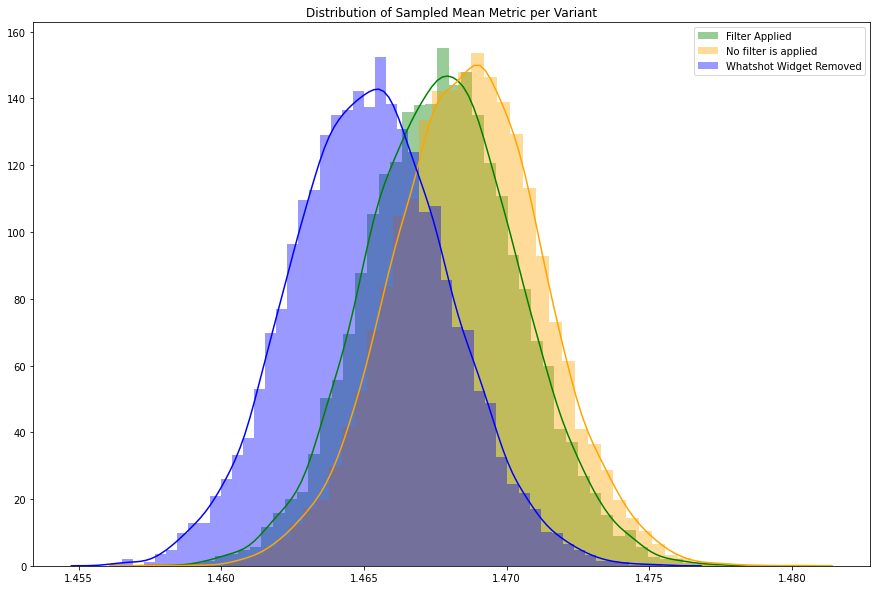

In [32]:
# Format data for BEST analysis

control = control_group.exp_metric

experimental = experimental_group.exp_metric

experimental_two = experimental_group_two.exp_metric

y1 = np.array(experimental)
y2 = np.array(control)
y = pd.DataFrame(dict(value=np.r_[y1, y2], group=np.r_[['experimental']*len(experimental), ['control']*len(control)]))

## Plot sampled means for metric in distribution plot

plt.figure(figsize=(15,10))
sb.distplot(dist_samples[['Filter Applied']], hist=True, color='green')
sb.distplot(dist_samples[['No filter is applied']], hist=True, color='orange')
sb.distplot(dist_samples[['Whatshot Widget Removed']], hist=True, color='blue')
plt.legend(labels=['Filter Applied','No filter is applied','Whatshot Widget Removed'])
plt.title("Distribution of Sampled Mean Metric per Variant")
plt.show()

user_experience
Filter Applied             1.467753
No filter is applied       1.468657
Whatshot Widget Removed    1.465240
Name: exp_metric, dtype: float64


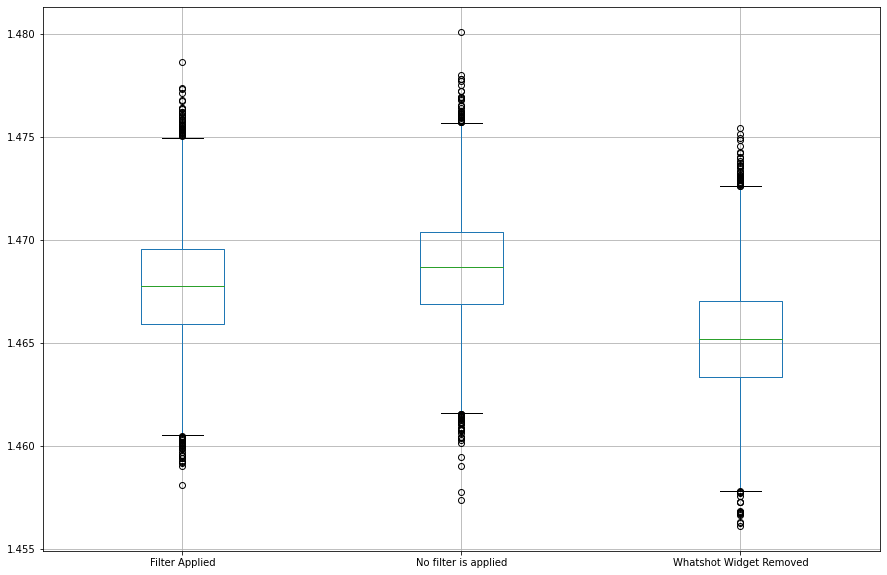

In [33]:
## Plot sampled means in boxplot for experimentation metric

plt.figure(figsize=(15,10))
dist_samples.boxplot(column=['Filter Applied', 
                                       'No filter is applied',
                                       'Whatshot Widget Removed'])

filtered = df.groupby(['user_experience']).mean()
filtered = filtered['exp_metric']
print(filtered)

In [34]:
# Set hyper-parameters for group means

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
# very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

μ_m = y.value.mean()
μ_s = y.value.std() * 2

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=μ_m, sd=μ_s)
    group2_mean = pm.Normal('group2_mean', mu=μ_m, sd=μ_s)

In [35]:
# Set hyper-parameters for group standard-deviations

# Since the means are real-valued, we will apply normal priors on them, 
# and arbitrarily set the hyperparameters to the pooled empirical mean of 
# the data and twice the pooled empirical standard deviation, which applies 
#very diffuse information to these quantities (and importantly, does not favor 
# one or the other a priori).

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

σ_low = 1
σ_high = 10

with model:
    group1_std = pm.Uniform('group1_std', lower=σ_low, upper=σ_high)
    group2_std = pm.Uniform('group2_std', lower=σ_low, upper=σ_high)

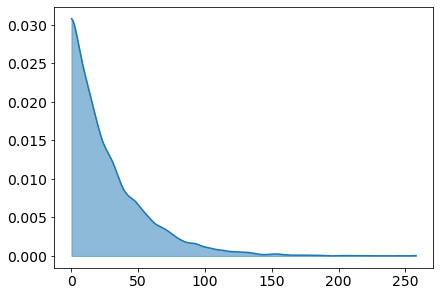

In [36]:
##  Set hyper-parameters for v (variance) 

# We follow Kruschke by making the prior for 𝜈 exponentially distributed with a mean of 30;
# this allocates high prior probability over the regions of the parameter that describe the 
# range from normal to heavy-tailed data under the Student-T distribution.

# The default form of the analysis program uses a noncommittal prior that has minimal 
# impact on the posterior distribution

with model:
    ν = pm.Exponential('ν_minus_one', 1/29.) + 1

pm.kdeplot(np.random.exponential(30, size=10000), fill_kwargs={'alpha': 0.5});

In [37]:
# Since PyMC3 parameterizes the Student-T in terms of precision, rather than standard deviation, 
# we must transform the standard deviations before specifying our likelihoods.

with model:
    λ1 = group1_std**-2
    λ2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=ν, mu=group1_mean, lam=λ1, observed=y1)
    group2 = pm.StudentT('placebo', nu=ν, mu=group2_mean, lam=λ2, observed=y2)

In [38]:
# Having fully specified our probabilistic model, we can turn our attention to calculating the comparisons of 
# interest in order to evaluate the effect of the intervention/experimental condition

with model:
    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size',
                                   diff_of_means / np.sqrt((group1_std**2 + group2_std**2) / 2))


In [39]:
# Now, we can fit the model and evaluate its output 

with model:
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, group2_std, group1_std, group2_mean, group1_mean]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 488 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


# Plotting the samples and the differences

We can plot the stochastic parameters of the model. PyMC’s plot_posterior function replicates the informative histograms portrayed in Kruschke (2012). These summarize the posterior distributions of the parameters, and present a 95% credible interval and the posterior mean. The plots below are constructed with the final 1000 samples from each of the 2 chains, pooled together.

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


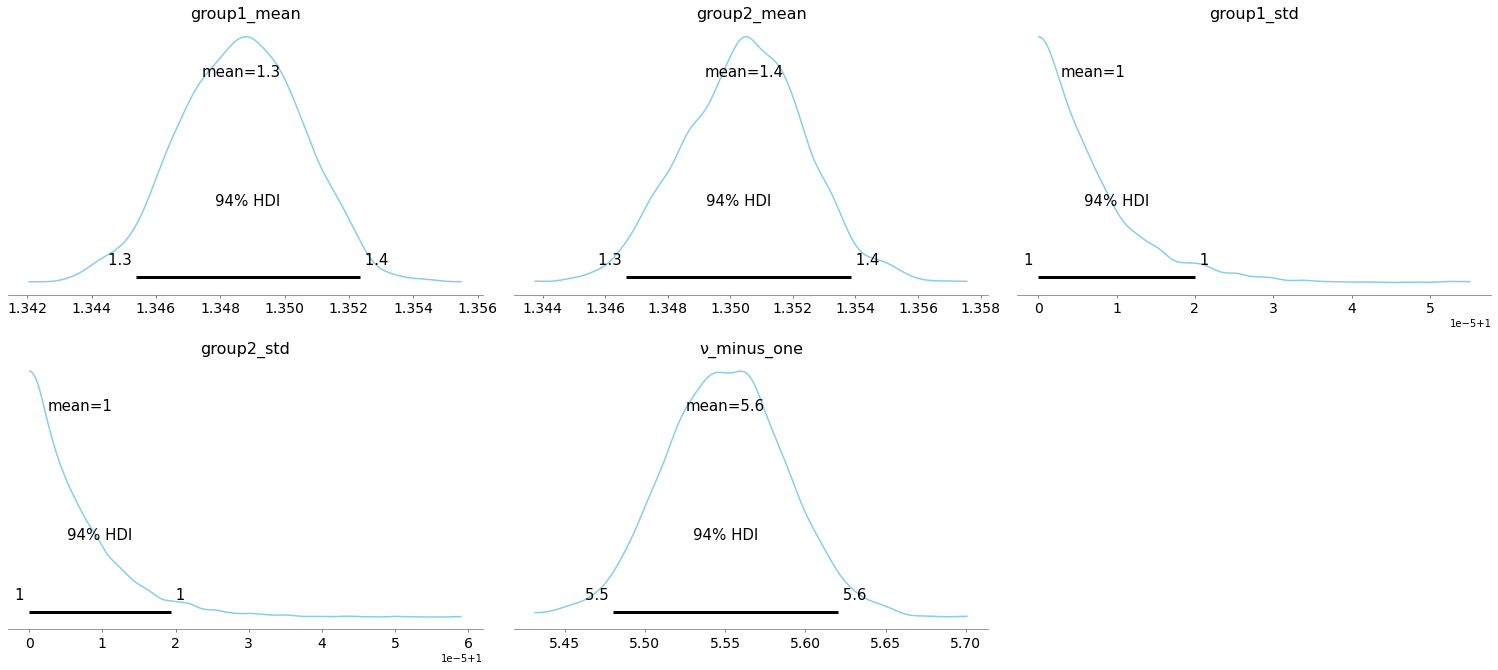

In [40]:
# Group means and sds

pm.plot_posterior(trace, var_names=['group1_mean','group2_mean', 'group1_std', 'group2_std', 'ν_minus_one'],
                  color='#87ceeb');

/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


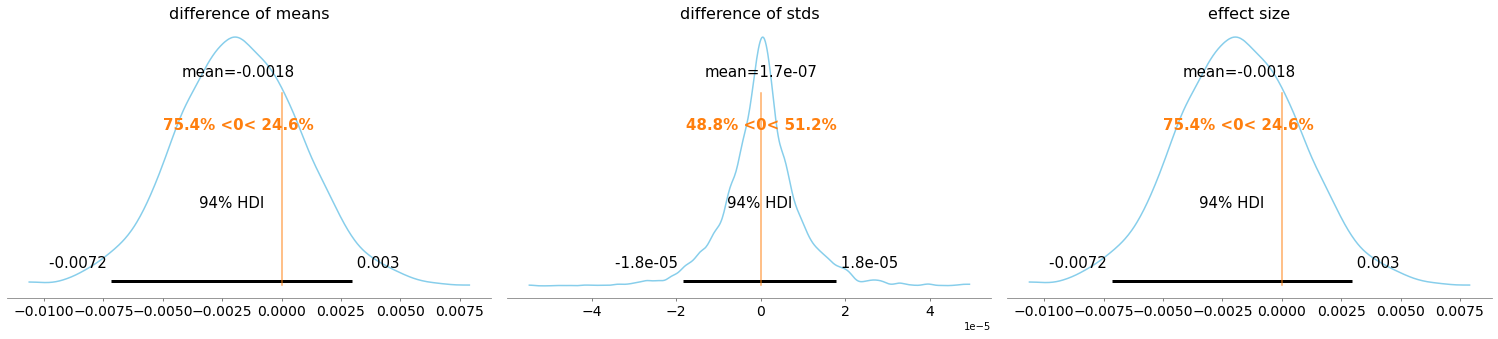

In [41]:
# Differences between groups and effect size

pm.plot_posterior(trace, var_names=['difference of means','difference of stds', 'effect size'],
                  ref_val=0,
                  color='#87ceeb');